<!-- # MoA RAG

- Author: [Kane](https://github.com/HarryKane11)
- Design: [Kane](https://github.com/HarryKane11)
- Peer Review : [syshin0116](https://github.com/syshin0116), [Jaehun Choi](https://github.com/ash-hun)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/06-DocumentLoader/08-WebBaseLoader.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/06-DocumentLoader/08-WebBaseLoader.ipynb)

## Overview

WebBaseLoader is a specialized document loader in LangChain designed for processing web-based content. 

It leverages the **BeautifulSoup4** library to parse web pages effectively, offering customizable parsing options through `SoupStrainer` and additional `bs4` parameters.

This tutorial demonstrates how to use WebBaseLoader to:
1. Load and parse web documents effectively
2. Customize parsing behavior using BeautifulSoup options
3. Handle different web content structures flexibly

### Table of Contents 

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Load Web-based documents](#load-web-based-documents)
- [Load Multiple URLs Concurrently with alazy_load](#load-multiple-urls-concurrently-with-alazy_load)
- [Load XML Documents](#load-xml-documents)
- [Load Web based document Using Proxies](#load-web-based-document-using-proxies)
- [Simple Web Content Loading with MarkItDown](#simple-web-content-loading-with-markitdown)

### References

- [WebBaseLoader API Documentation](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)
- [BeautifulSoup4 Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) -->

<!-- ## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details. -->

# MoA(Mixture of Agents) Search

- Author: [Kane](https://github.com/HarryKane11)
- Design:
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/02-RecommendationSystem/03-ResumeRecommendationReview.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/02-RecommendationSystem/03-ResumeRecommendationReview.ipynb)

## Overview

This code implements a sophisticated Multi-Model Search and Analysis System designed to provide comprehensive answers to user queries through a distributed search and analysis workflow. The system leverages multiple language models and parallel processing to gather and synthesize information from various perspectives.

The system architecture consists of three main components:

1) Query Generation and Distribution
The system begins by generating multiple search queries from the user's question using gpt-4o-mini, ensuring diverse perspectives in the information gathering process. These queries are then distributed across multiple language models (gpt-4o-mini, claude-haiku, and gemini-1.5-flash) for parallel processing.

2) Multi-Model Search and Analysis
Each generated query is processed independently using:
   - Tavily Search API for web results retrieval
   - Different language models (gpt-4o-mini, claude-3-5-haiku-20241022, gemini-1.5-flash-8b) for result analysis
   - Parallel execution for improved performance

1) Result Synthesis
The system collects and synthesizes all search results and analyses using gpt-4 as the final synthesizer, producing a comprehensive and accurate response to the original query.

**Key Features**:

- **Distributed Processing**:
 Implements a map-reduce pattern for parallel processing of search queries
 Utilizes multiple AI models to analyze search results from different perspectives

- **Multi-Model Architecture**:
 Incorporates three different language models:
   - gpt-4o-mini for query generation and intermediate analysis
   - claude-3-5-haiku-20241022 for rapid analysis
   - gemini-1.5-flash-8b for additional perspective

- **State Management**:
 Uses TypedDict for robust state management
 Maintains search queries, results, and model-specific analyses throughout the workflow

- **Flexible Workflow**:
 Implements a state graph architecture using LangGraph
 Supports conditional routing based on intermediate results
 Enables streaming of results for real-time updates

This system is particularly effective for complex queries requiring comprehensive information gathering and analysis, leveraging the strengths of multiple AI models to provide thorough and balanced responses.


### Table of Contents

### References

---


## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**

- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials.
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.


In [ ]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [1]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain-community",
        "langchain-openai",
        "langchain-anthropic",
        "langchain-google-genai",
        "langgraph"
    ],
    verbose=False,
    upgrade=False,
)

In [20]:
# Set environment variables

from langchain_opentutorial import set_env

set_env(
    {
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "07-Agent",
        "OPENAI_API_KEY":"",
        "ANTHROPIC_API_KEY":"",
        "GOOGLE_API_KEY":""
    }
)

Environment variables have been set successfully.


In [21]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [94]:
# Imports for required libraries and modules
import os
import operator
from typing import Annotated, List, Sequence, Dict
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langgraph.constants import Send

# Utility function to merge dictionaries
def dict_merge(old_dict: dict, new_dict: dict) -> dict:
    """Reducer function for merging dictionaries."""
    if not old_dict:
        return new_dict
    if not new_dict:
        return old_dict
    return {**old_dict, **new_dict}


## State and Models Setup
This section defines the `AgentState` structure for managing the workflow's state, 
along with the `SearchQueries` model for query generation. It also sets up the search tool 
and initializes multiple models with different characteristics.

In [97]:
# Define the agent's state using a TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # Message history
    search_queries: List[str]  # List of generated search queries
    raw_search_results: Annotated[Dict, dict_merge]  # Merged search results
    aggregated_search_results: str  # Combined search results as a single document
    model_responses: Annotated[Dict, dict_merge]  # Responses from different models
    final_answer: str  # Synthesized final answer

# Define a Pydantic model for search queries
class SearchQueries(BaseModel):
    queries: List[str] = Field(description="List of search queries")

# Set up the search tool
search_tool = TavilySearchResults(max_results=3)

# Configure multiple models with different characteristics
models = {
    "gpt-4o-mini": ChatOpenAI(model="gpt-4o-mini"),  # OpenAI GPT-4
    "claude-haiku": ChatAnthropic(model="claude-3-5-haiku-20241022"),  # Anthropic Claude
    "gemini-1.5-flash": ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")  # Google's Gemini
}


## Query Generation
This section defines a prompt template and combines it with a model to generate 3-5 
search queries that cover different aspects of the user's question.

In [98]:
# Define a prompt template for generating search queries
query_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", """Generate 3-5 different search queries to find comprehensive information about the user's question.
    Each query should focus on a different aspect or use different search terms to ensure broad coverage."""),
    ("human", "{question}")
])

# Combine the prompt with a model to generate queries
query_generator = query_gen_prompt | ChatOpenAI(model="gpt-4").with_structured_output(SearchQueries)

# Async function to generate queries based on the latest user message
async def generate_queries(state: AgentState) -> dict:
    """Generate search queries."""
    question = state["messages"][-1].content  # Get the latest user message
    result = await query_generator.ainvoke({"question": question})  # Generate queries
    print(f"Generated queries: {result.queries}")
    return {"search_queries": result.queries}  # Return the list of generated queries


In [99]:
query_generator.invoke("Is tesla's business strategy valid?")

SearchQueries(queries=["Analysis of Tesla's business strategy", "Tesla's business model effectiveness", "Pros and cons of Tesla's strategy", "Tesla's market share and business strategy", "Case studies on Tesla's business strategy"])

## Search Task Creation
This section creates tasks using `Send` objects for executing search queries in parallel. 
Each query will be processed independently.

In [100]:
# Function to create tasks for parallel search execution
def create_search_tasks(state: AgentState):
    """Create Send objects for parallel search processing."""
    return [
        Send("search_executor", {"query": query})  # Task for each search query
        for query in state["search_queries"]  # Iterate over all generated queries
    ]


## Search Execution
This section defines how each individual query is executed using the search tool 
and handles potential errors during execution.

In [101]:
# Async function to execute a single search
async def search_executor(state: dict) -> dict:
    """Execute individual search queries."""
    try:
        query = state["query"]  # Extract the query from the state
        print(f"Searching for: {query}")
        search_results = search_tool.invoke(query)  # Use the search tool to get results
        return {"raw_search_results": {query: search_results}}  # Return search results
    except Exception as e:
        print(f"Search error for query '{query}': {str(e)}")
        return {"raw_search_results": {}}  # Return empty results in case of an error


## Aggregating Search Results
This section combines raw search results from multiple queries into a single, 
structured document for easier analysis.

In [102]:
# Async function to aggregate raw search results into a single document
async def aggregate_search_results(state: AgentState) -> dict:
    """Combine multiple search results into a single document."""
    all_results = state.get("raw_search_results", {})  # Retrieve raw search results

    # Create a structured document from all search results
    aggregated_results = []
    for query, results in all_results.items():
        aggregated_results.append(f"Results for query '{query}':")
        for result in results:
            aggregated_results.append(f"- {result}")
    
    combined_results = "\n".join(aggregated_results)  # Combine results into a single string
    
    return {"aggregated_search_results": combined_results} 


## Analysis Task Creation
This section creates tasks for analyzing the aggregated search results using different models. 
Each model processes the results independently.

In [103]:
# Function to create analysis tasks for each model
def create_analysis_tasks(state: AgentState):
    """Create tasks for analyzing the aggregated search results with each model."""
    combined_results = state.get("aggregated_search_results", "")  # Get combined search results
    return [
        Send("model_analyzer", {
            "model_name": model_name,  # Specify the model name
            "search_results": combined_results  # Provide the combined results
        })
        for model_name in models.keys()  # Iterate over all available models
    ]


## Model Analysis
This section defines how individual models analyze the aggregated search results 
to provide their interpretations and insights.

In [105]:
# Async function to analyze search results using a specific model
async def model_analyzer(state: dict) -> dict:
    """Perform analysis of search results with an individual model."""
    try:
        model_name = state["model_name"]  # Extract the model name from the state
        search_results = state["search_results"]  # Get the aggregated search results
        
        # Define a prompt for the model to analyze the search results
        analysis_prompt = f"""Based on these search results, provide a comprehensive and accurate answer:
        Search Results: {search_results}
        """
        
        model = models[model_name]  # Retrieve the model instance
        response = await model.ainvoke([HumanMessage(content=analysis_prompt)])  # Get model's response
        
        # Return the model's analysis
        return {"model_responses": {model_name: response.content}}
    except Exception as e:
        print(f"Analysis error for model {model_name}: {str(e)}")
        # Return a placeholder response in case of an error
        return {"model_responses": {model_name: "Analysis failed"}}


## Synthesizing Results
This section synthesizes the responses from all models into a single, comprehensive answer 
that addresses the user's original question.

In [106]:
# Async function to synthesize responses from all models into a final answer
async def synthesize_results(state: AgentState) -> dict:
    """Combine analyses from all models into a single, comprehensive answer."""
    original_question = state["messages"][0].content  # Retrieve the original question
    model_responses = state["model_responses"]  # Get responses from all models
    
    # Define a prompt for synthesizing the final answer
    synthesis_prompt = f"""Original question: {original_question}
    Different AI models provided these analyses:
    {model_responses}
    
    Please synthesize these analyses into a single, comprehensive answer.
    Focus on points of agreement and highlight any significant differences in interpretation.
    Please answer in Korean.
    """
    
    synthesizer = ChatOpenAI(model="gpt-4o-mini", temperature=0)  # Use GPT-4 for synthesis
    final_response = await synthesizer.ainvoke([HumanMessage(content=synthesis_prompt)])  # Generate the final response
    
    # Return the final synthesized answer
    return {
        "final_answer": final_response.content,
        "messages": [AIMessage(content=final_response.content)]  # Add the response to message history
    }


In [109]:
workflow = StateGraph(AgentState)

# 노드 추가
workflow.add_node("query_generator", generate_queries)
workflow.add_node("search_executor", search_executor)
workflow.add_node("model_analyzer", model_analyzer)
workflow.add_node("synthesizer", synthesize_results)

# 엣지 추가
workflow.add_edge(START, "query_generator")
workflow.add_conditional_edges(
    "query_generator",
    create_search_tasks,
    {"search_executor": "search_executor"}
)
workflow.add_conditional_edges(
    "search_executor", 
    create_analysis_tasks,
    {"model_analyzer": "model_analyzer"}
)
workflow.add_edge("model_analyzer", "synthesizer")
workflow.add_edge("synthesizer", END)
app=workflow.compile()

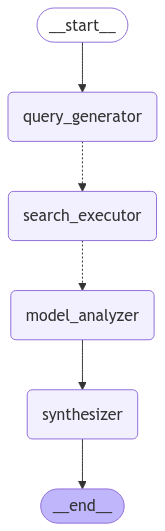

In [110]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [111]:
import nest_asyncio
nest_asyncio.apply()
%autoawait asyncio


In [113]:
# 테스트 실행
question = "테슬라 2025년 1분기 사업 전략 현황과 전망을 분석해줘"
inputs = {
    "messages": [HumanMessage(content=question)]
}

async for event in app.astream(inputs):
    print("\nEvent:", event)

Generated queries: ["Tesla's business strategy for the first quarter of 2025", "Analysis of Tesla's Q1 2025 business outlook", 'Tesla 2025 Q1 business performance and future projections', 'Tesla 2025 first quarter business review', "Forecasts for Tesla's business plan in Q1 2025"]

Event: {'query_generator': {'search_queries': ["Tesla's business strategy for the first quarter of 2025", "Analysis of Tesla's Q1 2025 business outlook", 'Tesla 2025 Q1 business performance and future projections', 'Tesla 2025 first quarter business review', "Forecasts for Tesla's business plan in Q1 2025"]}}
Searching for: Tesla's business strategy for the first quarter of 2025
Searching for: Analysis of Tesla's Q1 2025 business outlook
Searching for: Tesla 2025 Q1 business performance and future projections
Searching for: Tesla 2025 first quarter business review
Searching for: Forecasts for Tesla's business plan in Q1 2025

Event: {'search_executor': {'raw_search_results': {"Tesla's business strategy for t

'테슬라의 2025년 1분기 사업 전략 현황과 전망에 대한 분석을 종합하면 다음과 같습니다.

### 주요 사업 전략 하이라이트

1. **저렴한 전기차 개발**:
   - 테슬라는 약 25,000달러의 저렴한 전기차 모델 출시를 계획하고 있으며, 이는 전기차의 접근성을 높이고 시장 점유율을 확대하는 데 중요한 역할을 할 것으로 예상됩니다. 이 모델은 테슬라의 제품 라인업에서 중요한 위치를 차지할 것입니다.

2. **비용 절감**:
   - 생산 비용을 줄이기 위한 노력이 활발히 진행되고 있으며, 이는 저렴한 전기차 출시와 기존 제품의 마진 유지를 지원하는 데 필수적입니다. 공급망 최적화와 규모의 경제를 통해 비용 절감을 이루려는 전략이 강조되고 있습니다.

3. **완전 자율주행(FSD) 기술 확대**:
   - 테슬라는 2025년 1분기 동안 중국과 유럽에서 FSD 기술을 롤아웃할 계획입니다. 이는 자율주행 기술에서의 선두주자로 자리매김하기 위한 전략의 일환으로, 장기적인 비전과 수익성에 중요한 요소로 작용할 것입니다.

4. **판매 및 성장 전망**:
   - 2025년 차량 판매에서 약 30%의 성장을 예상하고 있으며, 이는 새로운 모델과 시장 조건에 대한 자신감을 반영합니다. 에너지 사업의 확장과 함께 연간 100GWh의 생산 목표를 설정하고 있습니다.

5. **에너지 사업 확대**:
   - 차량 판매 외에도 에너지 생산 이니셔티브를 확대하고 있으며, 이는 수익원 다각화와 재생 가능 에너지 솔루션에 대한 수요 증가를 활용하기 위한 전략으로 보입니다.

6. **주식 성과 및 시장 심리**:
   - 2024년 강력한 실적 발표 이후 테슬라의 주식은 긍정적인 성과를 보였으며, 투자자들 사이에서 장기 성장 가능성에 대한 낙관적인 전망이 유지되고 있습니다. 그러나 주식 시장의 변동성은 여전히 존재합니다.

7. **도전 과제 및 시장 역학**:
   - 긍정적인 전망에도 불구하고, 테슬라는 시장 경쟁, 규제 변화, 경제적 불확실성과 같은 도전 과제에 직면해 있습니다. 그러나 저렴한 차량 개발과 기술 혁신에 대한 전략적 전환은 지속적인 성장 가능성을 높이는 데 기여할 것입니다.

### 결론
테슬라의 2025년 1분기 전략은 저렴한 전기차 개발, 비용 절감, 자율주행 기술 확대, 에너지 사업 강화에 중점을 두고 있으며, 이러한 요소들이 결합되어 시장에서의 경쟁력을 유지하고 성장 목표를 달성하는 데 중요한 역할을 할 것으로 보입니다. 각 분석 모델 간의 주요 차이점은 특정 세부 사항에 대한 강조와 시장 전망의 신중함에 있으며, 전반적으로 테슬라는 긍정적인 성장 전망을 가지고 있습니다.